In [ ]:
pip install librosa

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

FUNDAMENTAL_FREQUENCY_USE_LIBROSA = False
SHOW_SPECTOGRAM_WITH_FUNDAMENTAL_FREQUENCY = False and FUNDAMENTAL_FREQUENCY_USE_LIBROSA

class file_data():
     """
    Class storing the data about the file together with label
    """
    def __init__(self, path, fundamental_frequencies, waveform, sampling_rate, label):
        """
        Creates new object calculating all the properties later used in classification based on fundamental frequency, waveform and sampling rate
        """
        self.path = path
        filtered_fundamental_frequencies = [x for x in fundamental_frequencies if not np.isnan(x)]
        self.fundamental_frequencies = sorted(filtered_fundamental_frequencies)
        
        self.meanfun = np.mean(self.fundamental_frequencies)
        self.q25 = np.percentile(self.fundamental_frequencies, 25)
        self.iqr = np.percentile(self.fundamental_frequencies, 75) - self.q25
        self.dfrange = self.fundamental_frequencies[-1] - self.fundamental_frequencies[0]
        self.stdev = np.std(self.fundamental_frequencies)
        self.skew = skew(self.fundamental_frequencies)
        self.mfcc = librosa.feature.mfcc(y = waveform, sr = sampling_rate, htk = False, n_mfcc = 12)
        self.mfcc = np.array(list(map(lambda x: np.mean(x), self.mfcc)))
        self.label = label
    def __str__(self):
        return f"{self.path}:\n\tmeanfun: {self.meanfun}\n\tq25: {self.q25}\n\tiqr: {self.iqr}\n\tdfrange: {self.dfrange}\n\tstdev: {self.stdev}\n\tskew: {self.skew}\n\tmfcc: {self.mfcc}\n\tlabel: {self.label}"

def get_label(path):
    """
    Returns the label of the file based on the path of the file
    """
    words = path.split("/")
    gender = words[1]
    if(gender == 'Male'):
        return 0
    else:
        return 1

def load_audio(path):
    """
    Loads the audio from path and creates file_data object with features
    """
    waveform, sampling_rate = librosa.load(path)
    label = get_label(path)
#     print(label)
    fundamental_frequencies = []
    # Calculate "by hand" using the algorithm from the tutorials
    if not FUNDAMENTAL_FREQUENCY_USE_LIBROSA:
        #We want to detect down to 50Hz, so we need 40 ms
        divide_into_n_parts = (waveform.shape[0]/sampling_rate)*25 # Divide into 40ms intervals
        if(int(divide_into_n_parts) != divide_into_n_parts):
            divide_into_n_parts = int(divide_into_n_parts) + 1
        
        splitted = np.array_split(waveform, divide_into_n_parts)
        
        for i in range(len(splitted)):
            section = splitted[i]
            # Additional padding at the end that won't affect results much but will get rid of edge cases
            if len(section) % 2 == 1:
                section = np.append(section, 0) # should not happen, but if it does, it will make calculations much easier without losing much
            
            # Algorithm from the tutorial
            middle_right_index = len(section) // 2 + 1
            mutual_coefficients = []
            for j in range(2, len(section) // 2):
                left = section[middle_right_index - j : middle_right_index]
                right = section[middle_right_index : middle_right_index + j]
                normalization_coeff = (np.linalg.norm(left) * np.linalg.norm(right))
                normalized_mutual_coefficient = np.dot(left, right) / normalization_coeff if normalization_coeff != 0 else 0
                mutual_coefficients.append(normalized_mutual_coefficient)
            
            max_value = max(mutual_coefficients)
            max_index = mutual_coefficients.index(max_value) + 2
            f0 = sampling_rate/max_index
            # If result is not in specified range (the range matches the one in librosa version) we assume there was no sound there
            if librosa.note_to_hz('C2') < f0 and f0 < librosa.note_to_hz('C7'): # To match librosa's range
                fundamental_frequencies.append(round(f0))
            else:
                fundamental_frequencies.append(np.nan)
    # Librosa implementation
    else:
        fundamental_frequencies, _, _ = librosa.pyin(waveform, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sampling_rate)
        print(fundamental_frequencies.shape)
        
    # Plot the spectrogram with fundamental frequency if enabled (and we used librosa)
    if SHOW_SPECTOGRAM_WITH_FUNDAMENTAL_FREQUENCY:
        S = np.abs(librosa.stft(waveform))
        times = librosa.times_like(fundamental_frequencies)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
        ax.set_title('Power spectrogram with fundamental frequency')
        ax.plot(times, fundamental_frequencies, label='f0', color='cyan', linewidth=3)
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
        plt.show()

    return file_data(path, fundamental_frequencies, waveform, sampling_rate, label)


#print(load_audio("Dataset/Female/0.wav"))
#print(load_audio("Dataset/Female/1.wav"))
#print(load_audio("Dataset/Male/0.wav"))
#print(load_audio("Dataset/Male/1.wav"))

C:\Users\gupta\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import os
import pandas as pd
# import librosa
# import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm.notebook import tqdm
# Define a wrapper function that takes in the input arguments for the load_audio function,
# calls the load_audio function with those arguments, and stores the output in a dictionary
def load_audio_to_df(path):
    audio_data = load_audio(path)
    data = {
        'path': audio_data.path,
        'fundamental_frequencies': audio_data.fundamental_frequencies,
        'meanfun': audio_data.meanfun,
        'q25': audio_data.q25,
        'iqr': audio_data.iqr,
        'dfrange': audio_data.dfrange,
        'stdev': audio_data.stdev,
        'skew': audio_data.skew,
        #'mfcc': audio_data.mfcc,
        'label': audio_data.label,
        'mfcc1': audio_data.mfcc[0],
        'mfcc2': audio_data.mfcc[1],
        'mfcc3': audio_data.mfcc[2],
        'mfcc4': audio_data.mfcc[3],
        'mfcc5': audio_data.mfcc[4],
        'mfcc6': audio_data.mfcc[5],
        'mfcc7': audio_data.mfcc[6],
        'mfcc8': audio_data.mfcc[7],
        'mfcc9': audio_data.mfcc[8],
        'mfcc10': audio_data.mfcc[9],
        'mfcc11': audio_data.mfcc[10],
        'mfcc12': audio_data.mfcc[11]
    }
    return data

# Define an empty list to store the data for each audio file
df_list = []

# Set the paths to the directories
wave_files_female = 'Dataset/Female'
wave_files_male = 'Dataset/Male'

# Get a list of all the files in the female directory
female_files = os.listdir(wave_files_female)

# Get a list of all the files in the male directory
male_files = os.listdir(wave_files_male)
# print(female_files)

# Iterate over the list of audio files
for audio_file in tqdm(female_files):
    # Load the female audio data and store it in the df_list
    df_list.append(load_audio_to_df(wave_files_female+'/'+audio_file))

for audio_file in tqdm(male_files):
    # Load the male audio data and store it in the df_list
    df_list.append(load_audio_to_df(wave_files_male+'/'+audio_file))
# Convert the list of dictionaries to a dataframe
data = pd.DataFrame(df_list)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [3]:
data.head()

,path,fundamental_frequencies,meanfun,q25,iqr,dfrange,stdev,skew,label,mfcc1,...,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,Dataset/Female/0.wav,"[84, 126, 142, 153, 159, 160, 160, 163, 163, 1...",335.217822,248.00,81.00,1294,219.422943,3.053616,1,-273.213531,...,-45.650753,67.070824,-32.634377,3.872809,-18.907183,3.297964,-1.834899,-8.221637,-4.426149,-4.183224
1,Dataset/Female/1.wav,"[98, 127, 133, 170, 178, 179, 179, 190, 190, 1...",376.705882,192.25,191.50,1907,389.368307,2.814954,1,-320.697968,...,-54.508400,33.786327,-47.468594,1.630078,-36.234894,-7.244123,-3.775545,-14.015665,-0.841133,-15.082652
2,Dataset/Female/10.wav,"[80, 83, 98, 100, 102, 104, 110, 117, 120, 127...",528.950000,103.50,1139.50,1616,605.326563,0.918588,1,-432.321808,...,-28.376503,39.545177,-10.863744,14.158586,-0.175361,5.115940,-9.835872,-8.614990,-8.713866,-14.238309
3,Dataset/Female/100.wav,"[89, 103, 103, 158, 165, 171, 172, 174, 174, 1...",560.727273,187.00,288.50,1916,651.817913,1.394561,1,-269.706085,...,-68.981606,43.187744,-19.676870,8.518633,-14.607292,-4.095662,-4.098593,1.616220,-3.007251,-7.093972
4,Dataset/Female/101.wav,"[106, 108, 143, 158, 160, 161, 165, 165, 167, ...",524.700000,175.25,718.25,1899,509.247971,1.262629,1,-328.830566,...,-33.600502,37.890385,-17.192480,10.857853,-21.298836,2.551567,-1.104004,3.557597,2.814285,-0.297360


In [20]:
import pandas as pd
import sklearn
from sklearn.svm import SVC

# Split the data into features and labels
# X = data[['meanfun', 'q25', 'iqr', 'dfrange', 'stdev', 'skew']]

X = data[['meanfun', 'q25', 'iqr', 'dfrange', 'stdev', 'skew', 'mfcc1', 'mfcc2', 'mfcc3','mfcc4','mfcc5','mfcc6',
'mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12']]

y = data['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))


Training cases: 400
Test cases: 100


SVM CLASSIFICATION

In [145]:
clf = SVC(kernel='linear',probability=True)

# Train the classifier on the training data
clf.fit(X_train, y_train)

#Printing Prediction
predictions = clf.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ' ,y_test)

# Test the classifier on the test data
accuracy = clf.score(X_test, y_test)

print(f"Accuracy: {accuracy}")

Predicted labels:  [0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0
 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1]
Actual labels:     313    0
328    0
73     1
402    0
210    1
      ..
191    1
368    0
32     1
95     1
200    1
Name: label, Length: 100, dtype: int64
Accuracy: 0.82


In [22]:
svm_accuracy = accuracy

Classification Report

In [146]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        48
           1       0.79      0.88      0.84        52

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.7931034482758621
Overall Recall: 0.8846153846153846


sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay

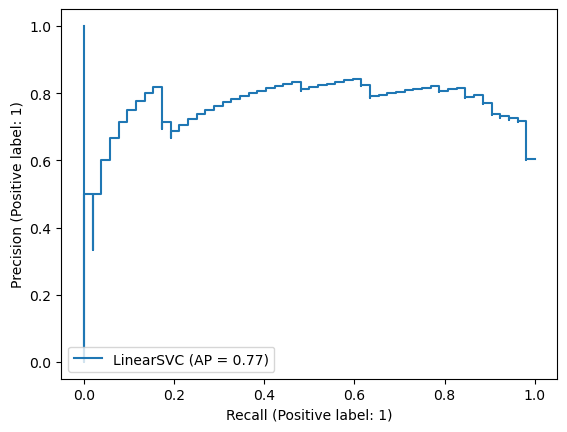

In [143]:
from sklearn.metrics import PrecisionRecallDisplay

y_decision_score = clf.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_decision_score,name="LinearSVC"
)
# display.ax_.set_title("2-class Precision-Recall curve")
type(display)

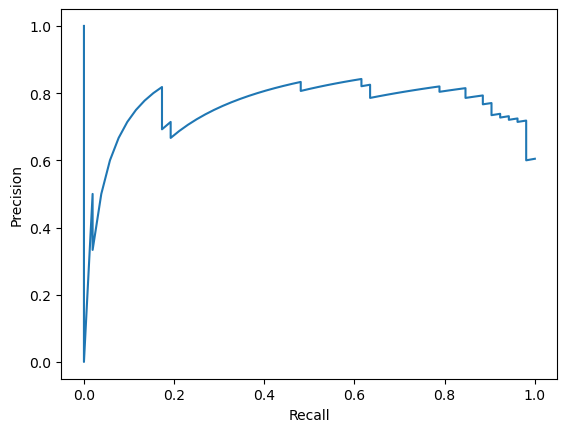

In [105]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt



# Compute the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_decision_score)

# Plot the precision recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('precision_recall_curve.png')
plt.show()


SVM Confusion Matrix

In [127]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
svm_cm = confusion_matrix(y_test, predictions)
print (cm)

[[32 16]
 [14 38]]


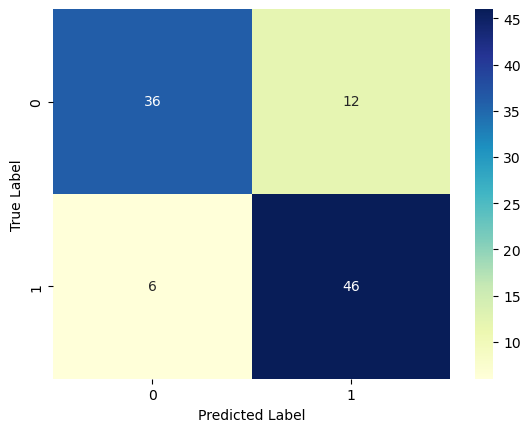

In [128]:
import seaborn as sns

# Example confusion matrix


# Create a heatmap of the confusion matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='YlGnBu')

# Add x and y axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('svm_confusion_matrix.png')
# Show the plot
plt.show()

SVM Proba Score

In [147]:
y_scores = clf.predict_proba(X_test)
print(y_scores)

[[9.17868880e-01 8.21311200e-02]
 [9.74931280e-01 2.50687204e-02]
 [2.33898055e-01 7.66101945e-01]
 [2.17156738e-01 7.82843262e-01]
 [3.77767479e-01 6.22232521e-01]
 [6.58401904e-02 9.34159810e-01]
 [7.39422398e-02 9.26057760e-01]
 [8.52852803e-01 1.47147197e-01]
 [8.57486609e-01 1.42513391e-01]
 [6.64371164e-01 3.35628836e-01]
 [6.13729642e-01 3.86270358e-01]
 [7.56228601e-02 9.24377140e-01]
 [5.40214355e-02 9.45978565e-01]
 [3.72927094e-01 6.27072906e-01]
 [1.56397566e-01 8.43602434e-01]
 [1.34169581e-02 9.86583042e-01]
 [9.28486068e-01 7.15139315e-02]
 [9.40580886e-01 5.94191142e-02]
 [9.75568659e-01 2.44313407e-02]
 [1.19974391e-01 8.80025609e-01]
 [6.15232171e-01 3.84767829e-01]
 [9.43094299e-01 5.69057007e-02]
 [9.79264807e-01 2.07351925e-02]
 [3.55293737e-02 9.64470626e-01]
 [8.48163223e-01 1.51836777e-01]
 [8.47514042e-01 1.52485958e-01]
 [4.85706203e-01 5.14293797e-01]
 [1.32458690e-01 8.67541310e-01]
 [9.59750604e-01 4.02493956e-02]
 [9.76472786e-01 2.35272138e-02]
 [7.676314

SVM ROC Chart

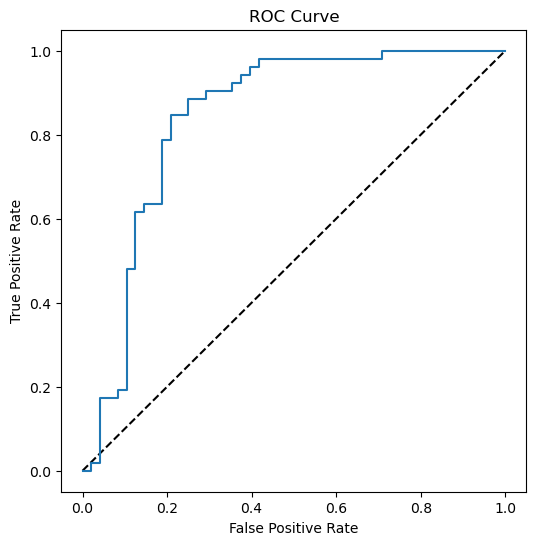

In [148]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('SVG_Roc_Curve.png')
plt.show()

# KNN CLASSIFICATION IMPLEMENTATION

In [64]:
knn_accuracy_list = []

In [129]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier


# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)

# Train the classifier on the training data
knn.fit(X_train, y_train)


#Printing Prediction
knn_predictions = knn.predict(X_test)
print('Predicted labels: ', knn_predictions)
print('Actual labels:    ' ,y_test)

# Test the classifier on the test data
knn_accuracy = knn.score(X_test, y_test)
# knn_accuracy_list.append(knn_accuracy)
# print(knn_accuracy_list)
print(f"Accuracy: {knn_accuracy}")

Predicted labels:  [1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1]
Actual labels:     313    0
328    0
73     1
402    0
210    1
      ..
191    1
368    0
32     1
95     1
200    1
Name: label, Length: 100, dtype: int64
Accuracy: 0.7


C:\Users\gupta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\gupta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

## KNN Classification Report

In [130]:
from sklearn. metrics import classification_report
target_names = ['Male 0', 'Female 1']
report = classification_report(y_test, knn_predictions,target_names=target_names)
print(report)

              precision    recall  f1-score   support

      Male 0       0.67      0.75      0.71        48
    Female 1       0.74      0.65      0.69        52

    accuracy                           0.70       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.70      0.70      0.70       100



KNN Precision and Recall

In [134]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, knn_predictions))
print("Overall Recall:",recall_score(y_test, knn_predictions))

Overall Precision: 0.7391304347826086
Overall Recall: 0.6538461538461539


Confusion matrix for KNN

In [56]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[32 16]
 [14 38]]


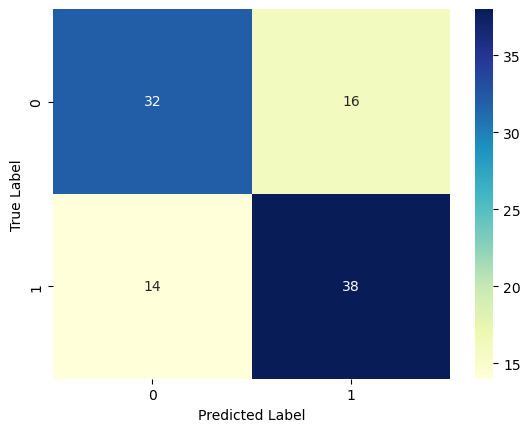

In [139]:
import seaborn as sns


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')

# Add x and y axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('knn_confusion_matrix.png')
# Show the plot
plt.show()

Proba scores

In [137]:
knn_y_scores = knn.predict_proba(X_test)
print(knn_y_scores)

[[0.25 0.75]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.   1.  ]
 [1.   0.  ]
 [0.5  0.5 ]
 [0.25 0.75]
 [1.   0.  ]
 [0.75 0.25]
 [0.25 0.75]
 [0.75 0.25]
 [0.75 0.25]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.75 0.25]
 [0.   1.  ]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.   1.  ]
 [1.   0.  ]
 [0.25 0.75]
 [1.   0.  ]
 [0.   1.  ]
 [1.   0.  ]
 [0.25 0.75]
 [0.25 0.75]
 [0.   1.  ]
 [0.   1.  ]
 [1.   0.  ]
 [0.5  0.5 ]
 [1.   0.  ]
 [0.   1.  ]
 [0.5  0.5 ]
 [0.   1.  ]
 [0.25 0.75]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [1.   0.  ]
 [0.75 0.25]
 [0.75 0.25]
 [0.25 0.75]
 [1.   0.  ]
 [0.75 0.25]
 [0.25 0.75]
 [0.   1.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.75 0.25]
 [0.   1.  ]
 [0.75 0.25]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [1.   0.  ]
 [0.25 0.75]
 [0.25 0.75]
 [0.25 0.75]
 [0.   1.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.25 0.75]
 [0.   1.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.25 0.75]
 [0.   1.  ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.5  0.5 ]
 [0.25 0.75]
 [0.75 0.25]
 [0.75 0.25]

ROC Chart

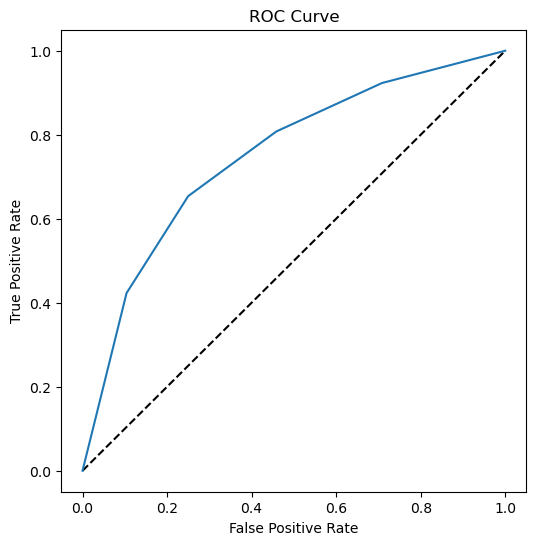

In [141]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn_y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('knn_roc_curve.png')
plt.show()

9


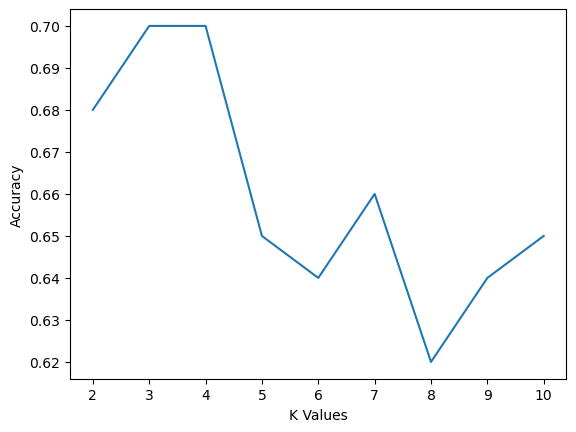

In [75]:
k_values = range(2,11)
print(len(knn_accuracy_list))
# accuracy = [0.58, 0.7, 0.68, 0.78, 0.66, 0.72, 0.7, 0.7, 0.74]
plt.plot(k_values, knn_accuracy_list)
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.savefig('AccuracyvKValues.png')
plt.show()

## Testing our own voices

In [109]:
recording_folder = ["Dataset/Recordings/Andra.wav", "Dataset/Recordings/Andrzej.wav", 
                    "Dataset/Recordings/Kasia.wav", "Dataset/Recordings/Ridhima.wav", "Dataset/Recordings/Anish.wav"]

In [110]:
recording_data = []

In [111]:
for recording in tqdm(recording_folder):
#     print(recording)
    rec_data = load_audio_to_df(recording)
    recording_data.append(rec_data)

  0%|          | 0/5 [00:00<?, ?it/s]

In [112]:
recording_df = pd.DataFrame(recording_data)

In [113]:
X_recording = recording_df[['meanfun', 'q25', 'iqr', 'dfrange', 'stdev', 'skew', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4','mfcc5','mfcc6',
'mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12']]

In [114]:
X_recording

,meanfun,q25,iqr,dfrange,stdev,skew,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,623.102941,102.25,879.50,1939,572.983604,0.906566,-445.158051,91.755783,18.646824,10.112305,-6.092076,4.485010,-0.551062,-1.872480,1.942937,-0.570975,-0.458286,-2.724176
1,796.964286,115.75,1459.25,1903,764.999042,0.447583,-369.797119,80.083595,-6.616527,40.360882,-8.408625,21.631916,-10.849783,5.965209,-20.253210,4.931169,-16.484457,-1.895734
2,603.000000,200.00,700.50,1928,625.056043,1.208681,-334.652802,54.209961,-13.229638,33.409161,-12.410889,11.244707,-12.888378,2.432728,-11.465822,2.266034,-12.497405,11.447806
3,523.389474,179.00,545.50,1937,514.092359,1.316291,-284.596649,136.270447,-8.266128,18.115585,-5.105680,-9.690672,-4.327013,-1.167726,-2.686136,5.960196,0.474676,3.406702
4,804.117647,136.25,1160.75,1931,650.818222,0.463174,-402.776550,95.042984,-23.461426,26.276800,-12.922263,5.089564,-11.217446,-0.589038,-8.148165,-8.632969,-9.528173,-13.667516


In [123]:
test_predictions = knn.predict(X_recording)
print(test_predictions)

[0 0 0 0 0]


C:\Users\gupta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [124]:
knn_rec_cm = confusion_matrix(y_true, test_predictions)
print (knn_rec_cm)

[[3 0]
 [2 0]]


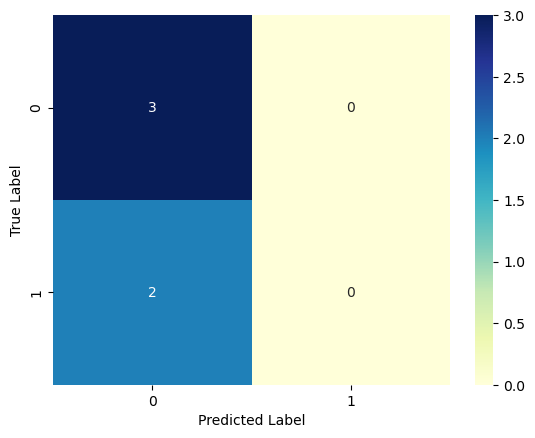

In [125]:
#KNN Heatmap
sns.heatmap(knn_rec_cm, annot=True, fmt='d', cmap='YlGnBu')

# Add x and y axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('self_recording_knn_confusion_matrix.png')
# Show the plot
plt.show()

In [116]:
test_predictions_svc = clf.predict(X_recording)
print(test_predictions_svc)

[0 0 1 1 0]


In [120]:
y_true = [0, 0, 1, 1, 0]

In [121]:
rec_cm = confusion_matrix(y_true, test_predictions_svc)
print (rec_cm)

[[3 0]
 [0 2]]


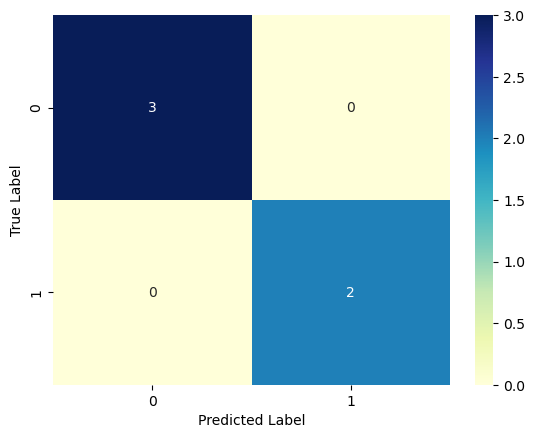

In [126]:
#SVM recording test dataset confustion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(rec_cm, annot=True, fmt='d', cmap='YlGnBu')

# Add x and y axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('self_recording_svm_confusion_matrix.png')
# Show the plot
plt.show()